In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import brier_score_loss, roc_auc_score, accuracy_score, f1_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import shap
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load dataset (replace path if needed)
df = pd.read_csv("diabetic_data.csv")

# Basic cleaning
df.replace('?', np.nan, inplace=True)
df.drop(columns=["encounter_id", "patient_nbr"], errors="ignore", inplace=True)

# Target setup: 1 = readmitted within 30 days, 0 = otherwise
df["readmitted"] = df["readmitted"].replace({"<30": 1, ">30": 0, "NO": 0}).astype(int)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (101766, 48)


,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,...,No,Steady,No,No,No,No,No,Ch,Yes,0


In [4]:
DATA_PATH = "diabetic_data.csv"    
TARGET_COL = "readmitted"          
TIME_COL = None                   
ID_COL = "encounter_id"          
num_cols = df.select_dtypes(include=["number"]).columns.drop(TARGET_COL, errors="ignore").tolist()
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

Numeric columns: 11
Categorical columns: 36


In [5]:
X = df.drop(columns=["readmitted"])
y = df["readmitted"]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# Numeric pipeline with KNNImputer
num_pipe = Pipeline([
    ("imp", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])

# Categorical pipeline
cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("enc", OneHotEncoder(handle_unknown="ignore"))
])

# Combine both
preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [6]:
# Fast Feature Selection using SelectFromModel (SFM)
# Fit RF on preprocessed data 
rf_sfm = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

# Select top features (median importance)
sfm = SelectFromModel(rf_sfm, threshold="median")
X_train_sel = sfm.fit_transform(X_train_pre, y_train)
X_test_sel = sfm.transform(X_test_pre)

# Get selected feature names
ohe = preprocessor.named_transformers_["cat"].named_steps["enc"]
cat_names = ohe.get_feature_names_out(cat_cols).tolist()
feature_names = list(num_cols) + cat_names  # ✅ Fixed here
selected_features = [f for f, s in zip(feature_names, sfm.get_support()) if s]
print(f"Selected {len(selected_features)} features using SFM")

Selected 1185 features using SFM


In [7]:

rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_pipe = Pipeline([("pre", preprocessor), ("clf", rf_model)])
rf_pipe.fit(X_train, y_train)

rf_probs = rf_pipe.predict_proba(X_test)[:, 1]
rf_preds = (rf_probs > 0.5).astype(int)

rf_auc = roc_auc_score(y_test, rf_probs)
rf_acc = accuracy_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)
rf_brier = brier_score_loss(y_test, rf_probs)

print(f"Random Forest → AUC: {rf_auc:.3f}, ACC: {rf_acc:.3f}, F1: {rf_f1:.3f}, Brier: {rf_brier:.3f}")


Random Forest → AUC: 0.636, ACC: 0.889, F1: 0.015, Brier: 0.096


In [8]:

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_estimators=50, random_state=42)
xgb_pipe = Pipeline([("pre", preprocessor), ("clf", xgb_model)])
xgb_pipe.fit(X_train, y_train)

xgb_probs = xgb_pipe.predict_proba(X_test)[:, 1]
xgb_preds = (xgb_probs > 0.5).astype(int)

xgb_auc = roc_auc_score(y_test, xgb_probs)
xgb_acc = accuracy_score(y_test, xgb_preds)
xgb_f1 = f1_score(y_test, xgb_preds)
xgb_brier = brier_score_loss(y_test, xgb_probs)

print(f"XGBoost → AUC: {xgb_auc:.3f}, ACC: {xgb_acc:.3f}, F1: {xgb_f1:.3f}, Brier: {xgb_brier:.3f}")

XGBoost → AUC: 0.681, ACC: 0.889, F1: 0.032, Brier: 0.094


In [9]:
svm_model = SVC(probability=True, kernel="rbf", class_weight="balanced", random_state=42)
svm_pipe = Pipeline([("pre", preprocessor), ("clf", svm_model)])

# Train on smaller subset for performance
svm_pipe.fit(X_train[:5000], y_train[:5000])

svm_probs = svm_pipe.predict_proba(X_test)[:, 1]
svm_preds = (svm_probs > 0.5).astype(int)
y_svm = y_test

svm_auc = roc_auc_score(y_svm, svm_probs)
svm_acc = accuracy_score(y_svm, svm_preds)
svm_f1 = f1_score(y_svm, svm_preds)
svm_brier = brier_score_loss(y_svm, svm_probs)

print(f"SVM → AUC: {svm_auc:.3f}, ACC: {svm_acc:.3f}, F1: {svm_f1:.3f}, Brier: {svm_brier:.3f}")


SVM → AUC: 0.631, ACC: 0.888, F1: 0.000, Brier: 0.097


In [10]:
import pandas as pd


results_df = pd.DataFrame([
    {"Model": "Random Forest", "AUC": rf_auc, "ACC": rf_acc, "F1": rf_f1, "Brier": rf_brier},
    {"Model": "XGBoost", "AUC": xgb_auc, "ACC": xgb_acc, "F1": xgb_f1, "Brier": xgb_brier},
    {"Model": "SVM (subset)", "AUC": svm_auc, "ACC": svm_acc, "F1": svm_f1, "Brier": svm_brier},
])

# Sort by AUC (best first)
results_df = results_df.sort_values(by="AUC", ascending=False).reset_index(drop=True)

# Table
print(" Model Performance Comparison:")
display(results_df)


 Model Performance Comparison:


,Model,AUC,ACC,F1,Brier
0,XGBoost,0.680909,0.888818,0.031665,0.094029
1,Random Forest,0.635565,0.888818,0.014802,0.096242
2,SVM (subset),0.631489,0.888425,0.000000,0.096734


In [11]:
from sklearn.calibration import CalibratedClassifierCV

X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_cal = CalibratedClassifierCV(rf_model, method="isotonic", cv=5)
rf_cal.fit(X_train_pre, y_train)
rf_probs_cal = rf_cal.predict_proba(X_test_pre)[:, 1]

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_cal = CalibratedClassifierCV(xgb_model, method="isotonic", cv=5)
xgb_cal.fit(X_train_pre, y_train)
xgb_probs_cal = xgb_cal.predict_proba(X_test_pre)[:, 1]

svm_model = SVC(probability=True, kernel="rbf", class_weight="balanced", random_state=42)
svm_cal = CalibratedClassifierCV(svm_model, method="isotonic", cv=3)
svm_cal.fit(X_train_pre[:5000], y_train[:5000])
svm_probs_cal = svm_cal.predict_proba(X_test_pre)[:, 1]


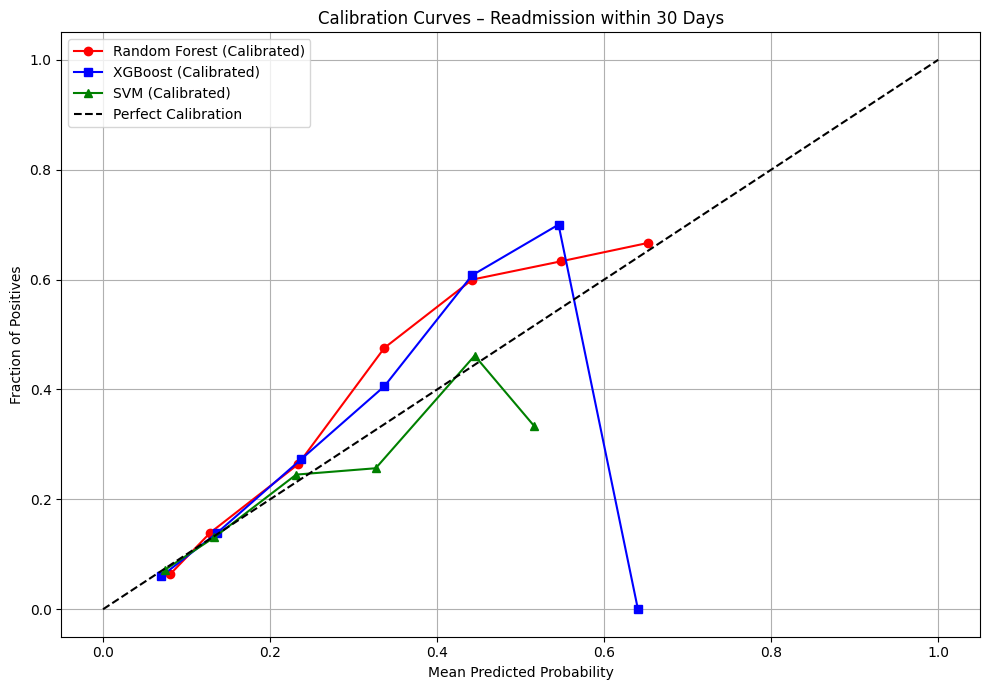

In [12]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

# Random Forest (Calibrated)
rf_true_cal, rf_pred_cal = calibration_curve(y_test, rf_probs_cal, n_bins=10)
plt.plot(rf_pred_cal, rf_true_cal, marker='o', linestyle='-', color='red', label='Random Forest (Calibrated)')

# XGBoost (Calibrated)
xgb_true_cal, xgb_pred_cal = calibration_curve(y_test, xgb_probs_cal, n_bins=10)
plt.plot(xgb_pred_cal, xgb_true_cal, marker='s', linestyle='-', color='blue', label='XGBoost (Calibrated)')

# SVM (Calibrated)
svm_true_cal, svm_pred_cal = calibration_curve(y_svm, svm_probs_cal, n_bins=10)
plt.plot(svm_pred_cal, svm_true_cal, marker='^', linestyle='-', color='green', label='SVM (Calibrated)')

# Perfect calibration line
plt.plot([0,1],[0,1],'k--', label='Perfect Calibration')

plt.title("Calibration Curves – Readmission within 30 Days")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
import numpy as np
import matplotlib.pyplot as plt

def decision_curve_analysis(y_true, y_prob, thresholds=np.linspace(0.01, 0.99, 100)):
    net_benefit = []
    for t in thresholds:
        preds = (y_prob >= t).astype(int)
        TP = np.sum((preds == 1) & (y_true == 1))
        FP = np.sum((preds == 1) & (y_true == 0))
        N = len(y_true)
        nb = (TP / N) - (FP / N) * (t / (1 - t))
        net_benefit.append(nb)
    return thresholds, net_benefit


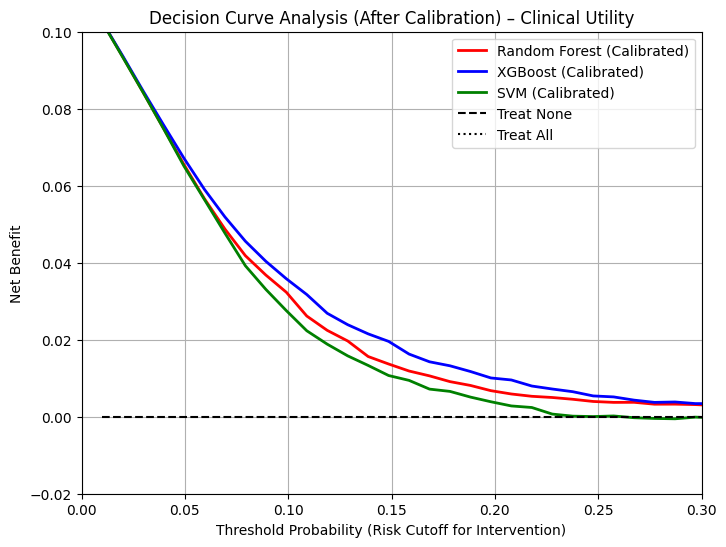

In [14]:
# Compute calibrated DCA
thresholds, rf_nb = decision_curve_analysis(y_test, rf_probs_cal)
_, xgb_nb = decision_curve_analysis(y_test, xgb_probs_cal)
_, svm_nb = decision_curve_analysis(y_test, svm_probs_cal)

plt.figure(figsize=(8,6))
plt.plot(thresholds, rf_nb, 'r-', lw=2, label="Random Forest (Calibrated)")
plt.plot(thresholds, xgb_nb, 'b-', lw=2, label="XGBoost (Calibrated)")
plt.plot(thresholds, svm_nb, 'g-', lw=2, label="SVM (Calibrated)")
plt.plot(thresholds, [0]*len(thresholds), 'k--', label="Treat None")
plt.plot(thresholds, [1 - t/(1-t) for t in thresholds], 'k:', label="Treat All")

plt.xlim(0, 0.3)
plt.ylim(-0.02, 0.1)
plt.xlabel("Threshold Probability (Risk Cutoff for Intervention)")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis (After Calibration) – Clinical Utility")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
from sklearn.metrics import brier_score_loss

print("Brier Scores (lower is better):")
print(f"Random Forest (Calibrated): {brier_score_loss(y_test, rf_probs_cal):.4f}")
print(f"XGBoost (Calibrated): {brier_score_loss(y_test, xgb_probs_cal):.4f}")
print(f"SVM (Calibrated): {brier_score_loss(y_test, svm_probs_cal):.4f}")


Brier Scores (lower is better):
Random Forest (Calibrated): 0.0949
XGBoost (Calibrated): 0.0937
SVM (Calibrated): 0.0966


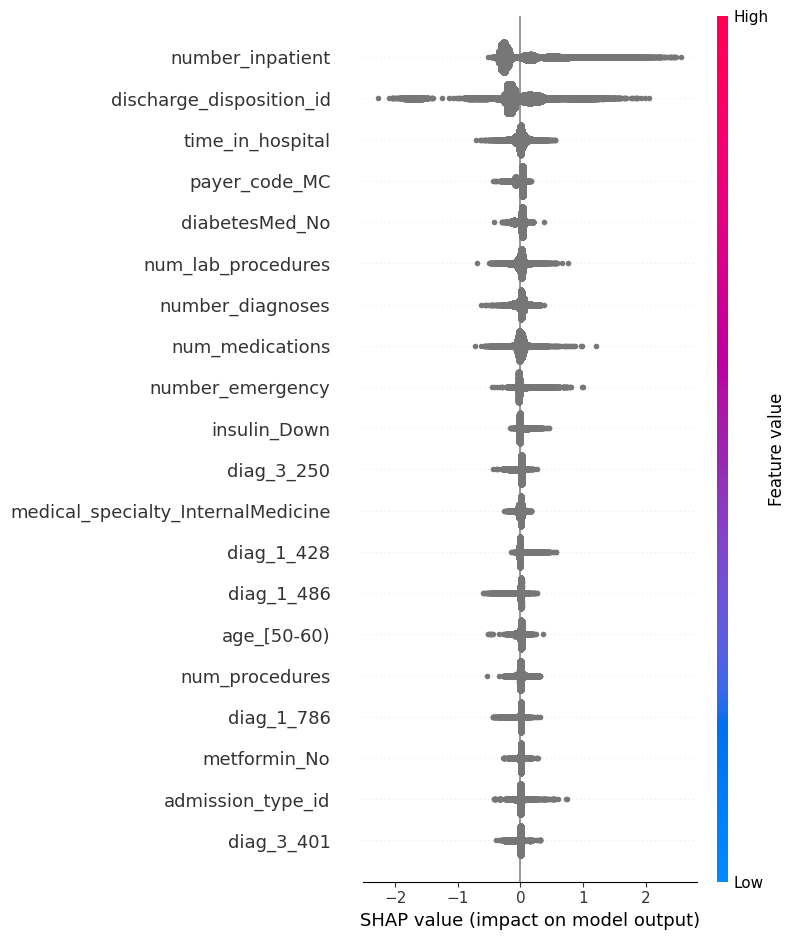

In [16]:
import shap

# Train XGB on preprocessed data
xgb_final = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
X_train_pre = preprocessor.fit_transform(X_train)
xgb_final.fit(X_train_pre, y_train)

explainer = shap.Explainer(xgb_final)
shap_values = explainer(X_train_pre)

shap.summary_plot(shap_values, features=X_train_pre, feature_names=list(num_cols) + list(ohe.get_feature_names_out(cat_cols)))


In [18]:
import shap
import numpy as np
import pandas as pd

# -----------------------------
# Sample the training data
# -----------------------------
sample_size = 5000  # adjust if you want faster or more precise
if X_train_pre.shape[0] > sample_size:
    sample_idx = np.random.choice(X_train_pre.shape[0], size=sample_size, replace=False)
    X_sample = X_train_pre[sample_idx]
else:
    X_sample = X_train_pre

# -----------------------------
# TreeExplainer for XGBoost
# -----------------------------
explainer = shap.TreeExplainer(xgb_final)
shap_values = explainer.shap_values(X_sample)  # fast, tree-based SHAP

# -----------------------------
# Compute mean absolute SHAP values
# -----------------------------
shap_abs = np.abs(shap_values).mean(axis=0)
shap_mean = shap_values.mean(axis=0)  # positive = ↑ readmission

# -----------------------------
# Select Top 15 features
# -----------------------------
top_idx = np.argsort(shap_abs)[::-1][:15]
top_features = [feature_names[i] for i in top_idx]
top_importances = shap_abs[top_idx]
top_direction = ["↑" if shap_mean[i] > 0 else "↓" for i in top_idx]

# -----------------------------
# Create DataFrame
# -----------------------------
top_shap_df = pd.DataFrame({
    "Rank": range(1, 16),
    "Feature": top_features,
    "Impact (Mean |SHAP|)": np.round(top_importances, 4),
    "Readmission Effect": top_direction
})

print("\nTop 15 Predictors Influencing 30-Day Readmission:\n")
print(top_shap_df.to_string(index=False))



Top 15 Predictors Influencing 30-Day Readmission:

 Rank                            Feature  Impact (Mean |SHAP|) Readmission Effect
    1                   number_inpatient                0.2992                  ↓
    2           discharge_disposition_id                0.2258                  ↓
    3                   time_in_hospital                0.0450                  ↑
    4                      payer_code_MC                0.0429                  ↓
    5                     diabetesMed_No                0.0421                  ↓
    6                 num_lab_procedures                0.0413                  ↓
    7                   number_diagnoses                0.0386                  ↑
    8                    num_medications                0.0360                  ↓
    9                   number_emergency                0.0341                  ↓
   10                       insulin_Down                0.0248                  ↑
   11                         diag_3_250      

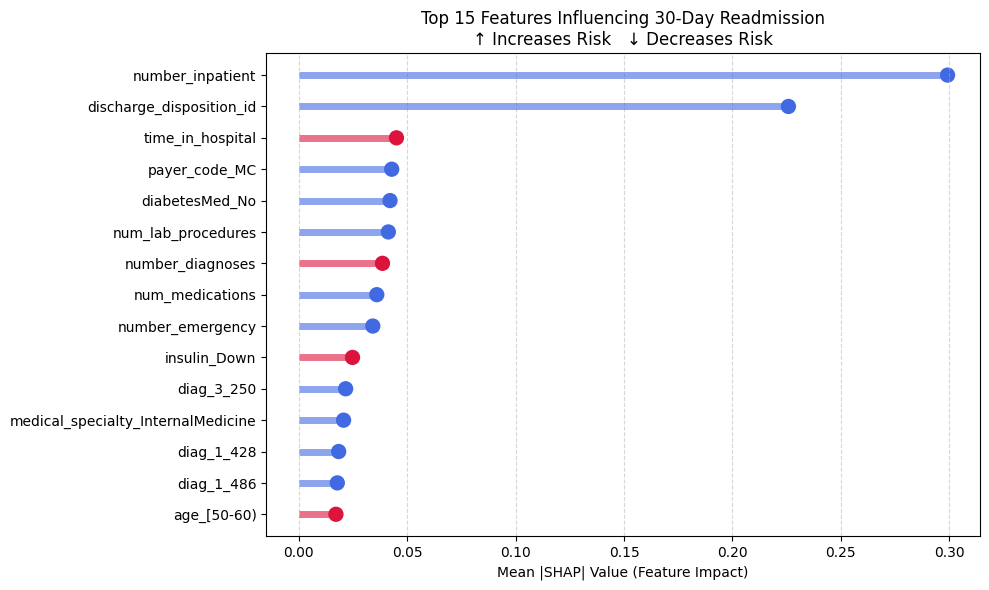

In [19]:
import matplotlib.pyplot as plt
import numpy as np

features = top_features[::-1]
importances = top_importances[::-1]
directions = top_direction[::-1]
colors = ["crimson" if d == "↑" else "royalblue" for d in directions]

plt.figure(figsize=(10, 6))
plt.hlines(y=features, xmin=0, xmax=importances, color=colors, alpha=0.6, linewidth=5)
plt.scatter(importances, features, color=colors, s=100)
plt.xlabel("Mean |SHAP| Value (Feature Impact)")
plt.title("Top 15 Features Influencing 30-Day Readmission\n↑ Increases Risk   ↓ Decreases Risk")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [20]:
import pandas as pd
from sklearn.metrics import brier_score_loss

# Compute Brier scores on calibrated probabilities
rf_brier_cal = brier_score_loss(y_test, rf_probs_cal)
xgb_brier_cal = brier_score_loss(y_test, xgb_probs_cal)
svm_brier_cal = brier_score_loss(y_svm, svm_probs_cal)

# Create summary DataFrame
summary_df = pd.DataFrame([
    {"Model": "Random Forest", "AUC": rf_auc, "Brier Score (Calibrated)": rf_brier_cal},
    {"Model": "XGBoost",      "AUC": xgb_auc, "Brier Score (Calibrated)": xgb_brier_cal},
    {"Model": "SVM",          "AUC": svm_auc, "Brier Score (Calibrated)": svm_brier_cal}
])

# Sort by Brier Score (lower is better)
summary_df = summary_df.sort_values(by="Brier Score (Calibrated)", ascending=True).reset_index(drop=True)

print("Model Performance Summary (AUC & Calibrated Brier Score):")
display(summary_df)


Model Performance Summary (AUC & Calibrated Brier Score):


,Model,AUC,Brier Score (Calibrated)
0,XGBoost,0.680909,0.093661
1,Random Forest,0.635565,0.094930
2,SVM,0.631489,0.096628
